In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from scipy.stats import power_divergence, chi2_contingency, chi2
from seaborn import barplot
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading and Cleaning Data

**--------------------------------------------------------------------**

**------------------------Load In The Data------------------------**

**--------------------------------------------------------------------**

In [ ]:
# Read in the file
filepath = 'Crime_Data_from_2020_to_Present.csv'
new_filepath = "/content/drive/MyDrive/Crime_Data_from_2020_to_Present.csv"
data = pd.read_csv(new_filepath,index_col=0)

In [ ]:
# Make it time-stamp
data['Date Rptd'] = pd.to_datetime(data['Date Rptd'], format='%m/%d/%Y %I:%M:%S %p')
data['TIME OCC'] = data['TIME OCC'].astype(str).str.zfill(4)  # Ensure it has 4 digits (e.g., '600' becomes '0600')
data['DATETIME OCC'] = pd.to_datetime(data['DATE OCC'].str.slice(stop=11) + data['TIME OCC'], format='%m/%d/%Y %H%M')
data = data.drop(columns=['DATE OCC', 'TIME OCC'])

In [ ]:
# Sort by time
data = data.sort_values(by='DATETIME OCC')

**--------------------------------------------------------------------**

**-------------------------Clean The Data-------------------------**

**--------------------------------------------------------------------**

In [ ]:
# Drop 7 cases where status is missing/unknown
data = data.dropna(subset=['Status'])
data = data[data['Status'] != 'CC']

# Drop 135 cases in which victim age is negative and replace age 0 with na
data = data[data['Vict Age'] >= 0]
data['Vict Age'] = data['Vict Age'].astype('Int64')
data['Vict Age'].replace(0, pd.NA, inplace=True)

<ipython-input-6-cfe69d7c82ab>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Vict Age'] = data['Vict Age'].astype('Int64')
<ipython-input-6-cfe69d7c82ab>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Vict Age'].replace(0, pd.NA, inplace=True)
<ipython-input-6-cfe69d7c82

In [ ]:
# Initialize dictionaries of descriptions (doesn't cover all crimes but includes the most serious ones)
area_dict = {}
crime_dict = {}
premise_dict = {}
status_dict = {}
weapons_dict = {}

for i in range(1, 22):
    area_dict[i] = data[data['AREA'] == i].iloc[0]['AREA NAME']

for code in sorted(data['Crm Cd'].unique()):
    crime_dict[code.item()] = data[data['Crm Cd'] == code].iloc[0]['Crm Cd Desc']

for code in sorted(data['Premis Cd'].unique()):
    if not np.isnan(code):
      premise_dict[code.item()] = data[data['Premis Cd'] == code].iloc[0]['Premis Desc']

for code in data['Status'].unique():
    if type(code) != float:
      status_dict[code] = data[data['Status'] == code].iloc[0]['Status Desc']

for code in data['Weapon Used Cd'].unique():
    if not np.isnan(code):
      weapons_dict[code.item()] = data[data['Weapon Used Cd'] == code].iloc[0]['Weapon Desc']

In [ ]:
print(area_dict)
print(crime_dict)
print(premise_dict)
print(status_dict)
print(weapons_dict)

{1: 'Central', 2: 'Rampart', 3: 'Southwest', 4: 'Hollenbeck', 5: 'Harbor', 6: 'Hollywood', 7: 'Wilshire', 8: 'West LA', 9: 'Van Nuys', 10: 'West Valley', 11: 'Northeast', 12: '77th Street', 13: 'Newton', 14: 'Pacific', 15: 'N Hollywood', 16: 'Foothill', 17: 'Devonshire', 18: 'Southeast', 19: 'Mission', 20: 'Olympic', 21: 'Topanga'}
{110: 'CRIMINAL HOMICIDE', 113: 'MANSLAUGHTER, NEGLIGENT', 121: 'RAPE, FORCIBLE', 122: 'RAPE, ATTEMPTED', 210: 'ROBBERY', 220: 'ATTEMPTED ROBBERY', 230: 'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT', 231: 'ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER', 235: 'CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT', 236: 'INTIMATE PARTNER - AGGRAVATED ASSAULT', 237: 'CHILD NEGLECT (SEE 300 W.I.C.)', 250: 'SHOTS FIRED AT MOVING VEHICLE, TRAIN OR AIRCRAFT', 251: 'SHOTS FIRED AT INHABITED DWELLING', 310: 'BURGLARY', 320: 'BURGLARY, ATTEMPTED', 330: 'BURGLARY FROM VEHICLE', 331: 'THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)', 341: 'THEFT-GRAND ($950.01 & OVER)EXCPT

In [ ]:
# Ensure the data in each column is of the correct datatype

# Temporary replace NaNs with -1 to allow floats to be made ints (to make them consistent) and then strings
data['Crm Cd 1'] = data['Crm Cd 1'].fillna(-1).astype(int).astype(str)  # Crime codes shouldn't be interpreted as numbers
data['Crm Cd 2'] = data['Crm Cd 2'].fillna(-1).astype(int).astype(str)  # Crime codes shouldn't be interpreted as numbers
data['Crm Cd 3'] = data['Crm Cd 3'].fillna(-1).astype(int).astype(str)  # Crime codes shouldn't be interpreted as numbers
data['Crm Cd 4'] = data['Crm Cd 4'].fillna(-1).astype(int).astype(str)  # Crime codes shouldn't be interpreted as numbers

# Replace -1s back with none
for col in ['Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4']:
    data[col] = data[col].replace('-1', "none")

In [ ]:
# One hot encode most common crimes
crime_frequency = {}
for i in range(1, 5):
  for code, count in data[f'Crm Cd {i}'].value_counts().items():
    if code != 'none':
      if code in crime_frequency:
        crime_frequency[code] += count
      else:
        crime_frequency[code] = count

for code, count in crime_frequency.items():
  if count > 10000:
    data[f'Crime {code}'] = (data['Crm Cd 1'] == code) | (data['Crm Cd 2'] == code) | (data['Crm Cd 3'] == code) | (data['Crm Cd 4'] == code)

data = data.drop('Crm Cd', axis=1)
data = data.drop('Crm Cd 1', axis=1)
data = data.drop('Crm Cd 2', axis=1)
data = data.drop('Crm Cd 3', axis=1)
data = data.drop('Crm Cd 4', axis=1)

# One hot encode most common weapons
for weapon, count in data['Weapon Used Cd'].value_counts().items():
  if count > 10000:
    data[f'Weapon {int(weapon)}'] = (data['Weapon Used Cd'] == weapon)

data = data.drop('Weapon Used Cd', axis=1)

# One hot encode most common premises
for premise, count in data['Premis Cd'].value_counts().items():
  if count > 10000:
    data[f'Premise {int(premise)}'] = (data['Premis Cd'] == premise)

data = data.drop('Premis Cd', axis=1)

# One hot encode most common ethnicities
for ethnicity, count in data['Vict Descent'].value_counts().items():
  if count > 10000:
    data[f'Vict {ethnicity}'] = (data['Vict Descent'] == ethnicity)

In [ ]:
# One hot encode male and female
data['Vict Male'] = (data['Vict Sex'] == 'M')
data['Vict Female'] = (data['Vict Sex'] == 'F')
data = data.drop('Vict Sex', axis=1)

In [ ]:
# Replace Part 1/2 with more descriptive label
data['Violent/Property'] = (data['Part 1-2'] == 1)
data = data.drop('Part 1-2', axis=1)

In [ ]:
# Remove descriptive columns
data = data.drop('AREA', axis=1)  # This information is also included in AREA NAME
data = data.drop('Crm Cd Desc', axis=1)
data = data.drop('Weapon Desc', axis=1)
data = data.drop('Premis Desc', axis=1)
data = data.drop('Status Desc', axis=1)

# There are 1210 unique values; too specific of an area to provide significant information
data = data.drop('Rpt Dist No', axis=1)
# Too many unique values; also included in lat/long
data = data.drop('LOCATION', axis=1)
# Too many unique and missing values; also included in lat/long
data = data.drop('Cross Street', axis=1)

# Could be used for specific inquiries but don't appear to be useful now
data = data.drop('Mocodes', axis=1)

**--------------------------------------------------------------------**

**-------------------------Train-Test Split-------------------------**

**--------------------------------------------------------------------**

In [ ]:
# Aggregate crimes into daily quantities
time_data = data['Violent/Property'].astype(int).copy()
time_data.index = pd.DatetimeIndex(data['DATETIME OCC'])
severe_daily_crimes = time_data.resample('D').sum()[:-100]
all_daily_crimes = time_data.resample('D').count()[:-100]

# Split daily crime totals based on time
n = len(severe_daily_crimes)
train_severe, train_all = severe_daily_crimes[:int(0.7*n)], all_daily_crimes[:int(0.7*n)]
val_severe, val_all = severe_daily_crimes[int(0.7*n):int(0.8*n)], all_daily_crimes[int(0.7*n):int(0.8*n)]
test_severe, test_all = severe_daily_crimes[int(0.8*n):], all_daily_crimes[int(0.8*n):]

In [ ]:
# Completely Random Train-Validation-Test Split of All Data
data_training, data_test = train_test_split(data, test_size=0.2, random_state=42)
data_train, data_val = train_test_split(data_training, test_size=0.2, random_state=42)

In [ ]:
print("Length of Cleaned Dataset:", len(data))

Length of Cleaned Dataset: 1004962


# Finding the Trend

In [ ]:
def moving_average(time_series, period):
  if period % 2 == 1:
    T = np.zeros(len(time_series) - period + 1)  # Initialize the trend with 0s
    indices = np.arange(period) - period//2  # Indices correspond to moving window
    times = period//2 + np.arange(len(time_series) - period + 1)
  else:
    T = np.zeros(len(time_series) - period)  # Initialize the trend with 0s
    indices = np.arange(period+1) - period//2  # Indices correspond to moving window
    times = period//2 + np.arange(len(time_series) - period)

  # For each element in the time series with sufficient entries around it
  for i in range(period//2, len(time_series)-period//2):
    values = time_series[indices+i]  # Shift indices by index in time-series
    if period % 2 == 1: sum = np.sum(values)  # Odd moving average
    else:  # Even moving average
      sum = 0
      for j, value in enumerate(values):
        if j==0 or j==period//2+1: sum+=value/2  # m is even
        else: sum += value
    T[i-period//2] = sum/period   # Store moving average

  return times, T

def find_seasonal(y, period):
  S = np.zeros_like(y)
  for k in range(period):  # Compute mean for every other period elements
    S[k::period] = np.mean(y[k::period])
  return S

In [ ]:
def split_series(time_series, period_yearly, period_weekly, plot=True):
  # Get the trend and seasonal component (as if there was only a yearly trend)
  ts, T_yearly = moving_average(time_series, period=period_yearly)
  y_detrended_yearly = time_series[ts]-T_yearly  # Detrended series
  S_yearly = find_seasonal(y_detrended_yearly, period=period_yearly)
  ts_weekly_moving_avg, T_weekly_moving_avg = moving_average(time_series, period=period_weekly)  # Moving average for week
  # S_weekly1 = find_seasonal(time_series[ts_weekly1] - T_weekly1, period=period_weekly)

  # Subtract off yearly seasonal component to allow us to find weekly component
  y_detrended_yearly_seasonal  = y_detrended_yearly - S_yearly
  S_weekly = find_seasonal(y_detrended_yearly_seasonal, period=period_weekly)

  # Find the residual
  residual = time_series[ts] - T_yearly - S_yearly - S_weekly

  if plot:
    plt.figure(figsize=(9, 3))
    plt.title("Crimes In Las Angeles")
    plt.xlabel("Day")
    plt.ylabel("Number of Crimes")
    plt.plot(time_series, lw=.3, label="Time Series")
    plt.plot(ts, T_yearly, label="Yearly Moving Average")
    plt.plot(ts_weekly_moving_avg, T_weekly_moving_avg, lw=0.4, color="black", label="Weekly Moving Average")
    plt.legend()
    plt.show()
    plt.show()

    plt.figure(figsize=(9, 4.5))

    plt.subplot(2,2,1)
    plt.title("Trend")
    plt.xlabel("Day")
    plt.ylabel("Crimes")
    plt.plot(ts, T_yearly)

    plt.subplot(2,2,2)
    plt.title("Yearly Seasonal Component")
    plt.xlabel("Time")
    plt.ylabel("Crimes")
    plt.plot(ts[:period_yearly+1], S_yearly[:period_yearly+1])

    # Note t=0 corresponds to a Wednesday (as that was the first day of 2020)
    ax = plt.subplot(2,2,3)
    plt.title("Weekly Seasonal Component")
    plt.xlabel("Day")
    plt.ylabel("Crimes")
    plt.plot(np.arange(period_weekly+1), S_weekly[4:period_weekly+5])
    date_range = pd.date_range(start="2020-01-05", periods=period_weekly+1, freq='D')
    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    ax.set_xticks(np.arange(0, len(date_range), 1))  # Every day
    ax.set_xticklabels([weekdays[date.weekday()] for date in date_range], rotation=45)

    plt.subplot(2,2,4)
    plt.title("Residual")
    plt.xlabel("Day")
    plt.ylabel("Crimes")
    plt.plot(ts, residual)
    plt.tight_layout()
    plt.savefig("Detrended.png")
    plt.show()

  return ts, T_yearly, S_yearly, S_weekly, residual

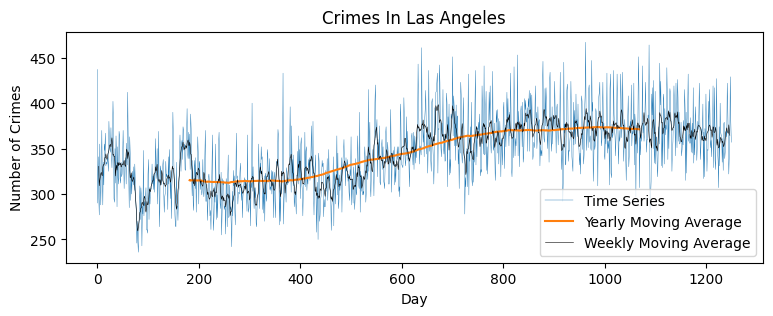

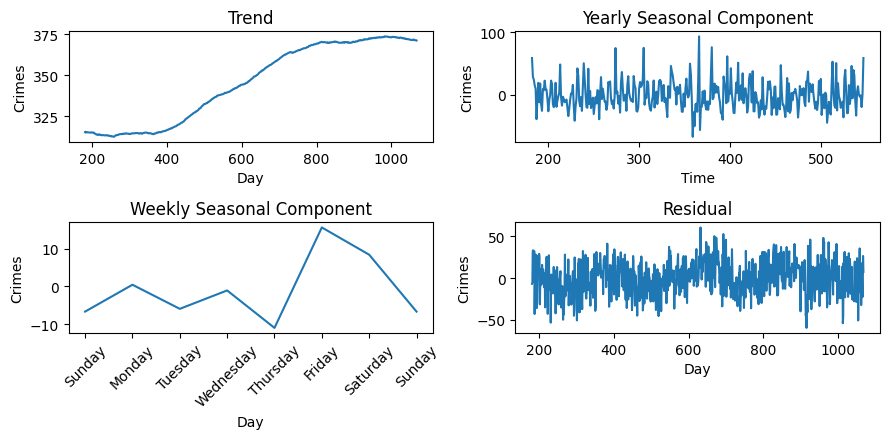

In [ ]:
severe_time_series = np.copy(train_severe.values)

# Remove the two outliers (found from plotting it)
severe_time_series[150] = (severe_time_series[149]+severe_time_series[151])/2
severe_time_series[152] = (severe_time_series[151]+severe_time_series[153])/2

severe_ts, train_severe_T_yearly, train_severe_S_yearly, train_severe_S_weekly, \
  train_severe_residual = split_series(severe_time_series, period_yearly=365, period_weekly=7)

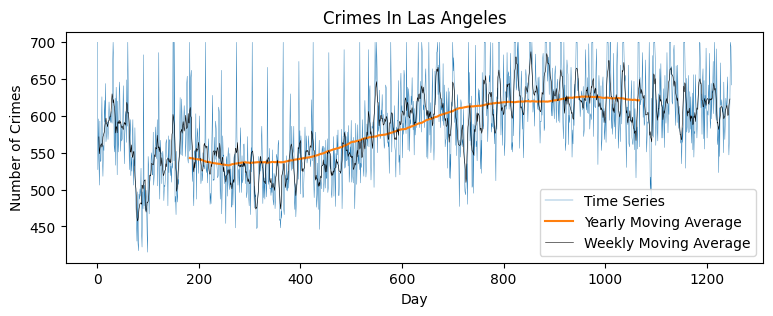

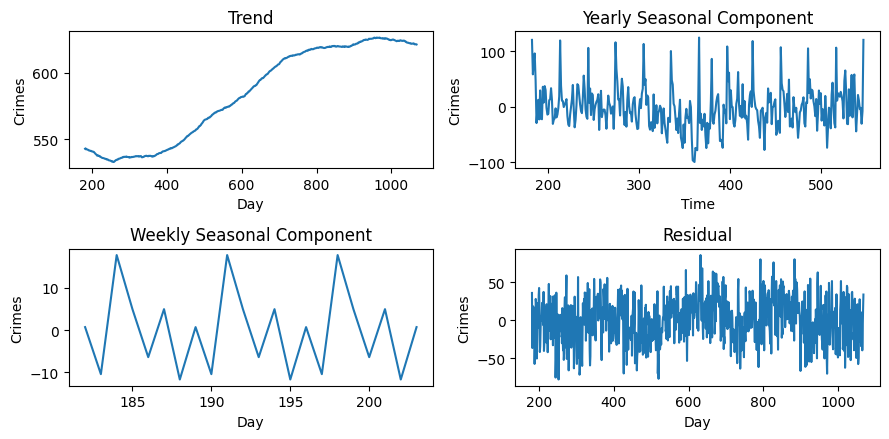

In [ ]:
all_time_series = np.copy(train_all.values)

# Remove outliers
all_time_series = np.clip(all_time_series, 400, 700)

all_ts, train_all_T_yearly, train_all_S_yearly, train_all_S_weekly, \
  train_all_residual = split_series(all_time_series, period_yearly=365, period_weekly=7)

In [ ]:
time_series = data[data[weapon] == True]["Violent/Property"].astype(int).copy()
time_series.index = pd.DatetimeIndex(data[data[weapon] == True]['DATETIME OCC'])
# We snsure that we are only getting the train dataset
weapon_severe_daily_crimes = np.array(time_series.resample('D').sum()[:-100])[:int(0.7*n)]
weapon_all_daily_crimes = time_series.resample('D').count()[:-100][:int(0.7*n)]
print(weapon_all_daily_crimes.index[0])
print(len(weapon_all_daily_crimes))
# So the first day is the

2020-01-01 00:00:00
1250


# Exploring Trends Across Different Keys
Due to the abundance of keys to pivot on, the code below can be run to pivot on a different key:
```python
partition_type = ["Crime", "Premise", "Ethnicity", "Sex", "Weapon", "AREA NAME", "Age"]
```
The different options are listed above. Note that some elements such as Crime have many different options so the graphs become quite large.

In [ ]:
# I am slightly altering Dannys code so I can do side by side comparisons
def split_series_compare(time_series, period_yearly, period_weekly, plot=True, color="b", line="-", label="None", axes = None, severity=None):
  # Get the trend and seasonal component (as if there was only a yearly trend)
  ts, T_yearly = moving_average(time_series, period=period_yearly)
  y_detrended_yearly = time_series[ts]-T_yearly  # Detrended series
  S_yearly = find_seasonal(y_detrended_yearly, period=period_yearly)
  ts_weekly_moving_avg, T_weekly_moving_avg = moving_average(time_series, period=period_weekly)  # Moving average for week
  # S_weekly1 = find_seasonal(time_series[ts_weekly1] - T_weekly1, period=period_weekly)

  # Subtract off yearly seasonal component to allow us to find weekly component
  y_detrended_yearly_seasonal  = y_detrended_yearly - S_yearly
  S_weekly = find_seasonal(y_detrended_yearly_seasonal, period=period_weekly)

  # Find the residual
  residual = time_series[ts] - T_yearly - S_yearly - S_weekly
  if plot:
    date_range = pd.date_range(start="2020-01-01", periods=1250, freq='D')
    first_of_months = date_range[date_range.day == 1]
    axes[0].set_title(f"The Yearly Trend by {label}")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel("Number of Crimes")
    line1, = axes[0].plot(time_series, lw=.3, label="_")
    first_of_month_indices = [date_range.get_loc(date) for date in first_of_months[::2]]
    axes[0].plot(ts, T_yearly, label=label, color=color)
    axes[0].set_xticks(first_of_month_indices)
    axes[0].set_xticklabels([date.strftime('%Y-%m-%d') for date in first_of_months[::2]], rotation=45)
    line1.remove()
    axes[0].relim()  # Recalculate limits based on current data
    axes[0].autoscale(axis='y')  # Autoscale only the y-axis
    # axes[0].legend(locf"C{i}"=1,ncols=3)
    start_index = date_range.get_loc(pd.Timestamp("2020-07-01"))
    end_index = date_range.get_loc(pd.Timestamp("2022-09-30"))

    axes[0].set_xlim(start_index, end_index)
    for date in first_of_month_indices:
      axes[0].axvline(date, color='gray', linestyle=':', alpha=0.5)

    axes[1].set_title(f"Yearly Seasonal Component {severity}")
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel("Number of Crimes")
    date_range = pd.date_range(start="2020-01-01", periods=365, freq='D')
    first_of_months = date_range[date_range.day == 1]
    first_of_month_indices = [date_range.get_loc(date) for date in first_of_months]
    axes[1].plot(np.arange(period_yearly), S_yearly[:period_yearly], color=color, linestyle=line)
    axes[1].set_xticks(first_of_month_indices)
    axes[1].set_xticklabels([date.strftime('%Y-%m-%d') for date in first_of_months], rotation=45)
    for date in first_of_month_indices:
      axes[1].axvline(date, color='gray', linestyle=':', alpha=0.5)
    # axes[1].legend(loc=1,ncols=3)

    # Note t=0 corresponds to a Wednesday (as that was the first day of 2020)
    axes[2].set_title(f"Weekly Seasonal Component by {label}")
    axes[2].set_xlabel("Time")
    axes[2].set_ylabel("Number of Crimes")
    axes[2].plot(np.arange(period_weekly+1), S_weekly[4:period_weekly+5], color=color, linestyle=line)
    # axes[2].legend(loc=1,ncols=3)
    date_range = pd.date_range(start="2020-01-05", periods=period_weekly+1, freq='D')
    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    axes[2].set_xticks(np.arange(0, len(date_range), 1))  # Every day
    axes[2].set_xticklabels([weekdays[date.weekday()] for date in date_range], rotation=45)

    date_range = pd.date_range(start="2020-01-01", periods=1250, freq='D')
    first_of_months = date_range[date_range.day == 1]
    axes[3].set_title(f"Residual {severity}")
    axes[3].set_xlabel("Time")
    axes[3].set_ylabel("Number of Crimes")
    line1, = axes[3].plot(time_series, lw=.3, label="_")
    first_of_month_indices = [date_range.get_loc(date) for date in first_of_months[::2]]
    axes[3].plot(ts, residual, color=color, linestyle=line, alpha=.5)
    # axes[3].legend(loc=1,ncols=3)
    axes[3].set_xticks(first_of_month_indices)
    axes[3].set_xticklabels([date.strftime('%Y-%m-%d') for date in first_of_months[::2]], rotation=45)
    line1.remove()
    axes[3].relim()  # Recalculate limits based on current data
    axes[3].autoscale(axis='y')  # Autoscale only the y-axis
    for date in first_of_month_indices:
      axes[3].axvline(date, color='gray', linestyle=':', alpha=0.5)

  return ts, T_yearly, S_yearly, S_weekly, residual



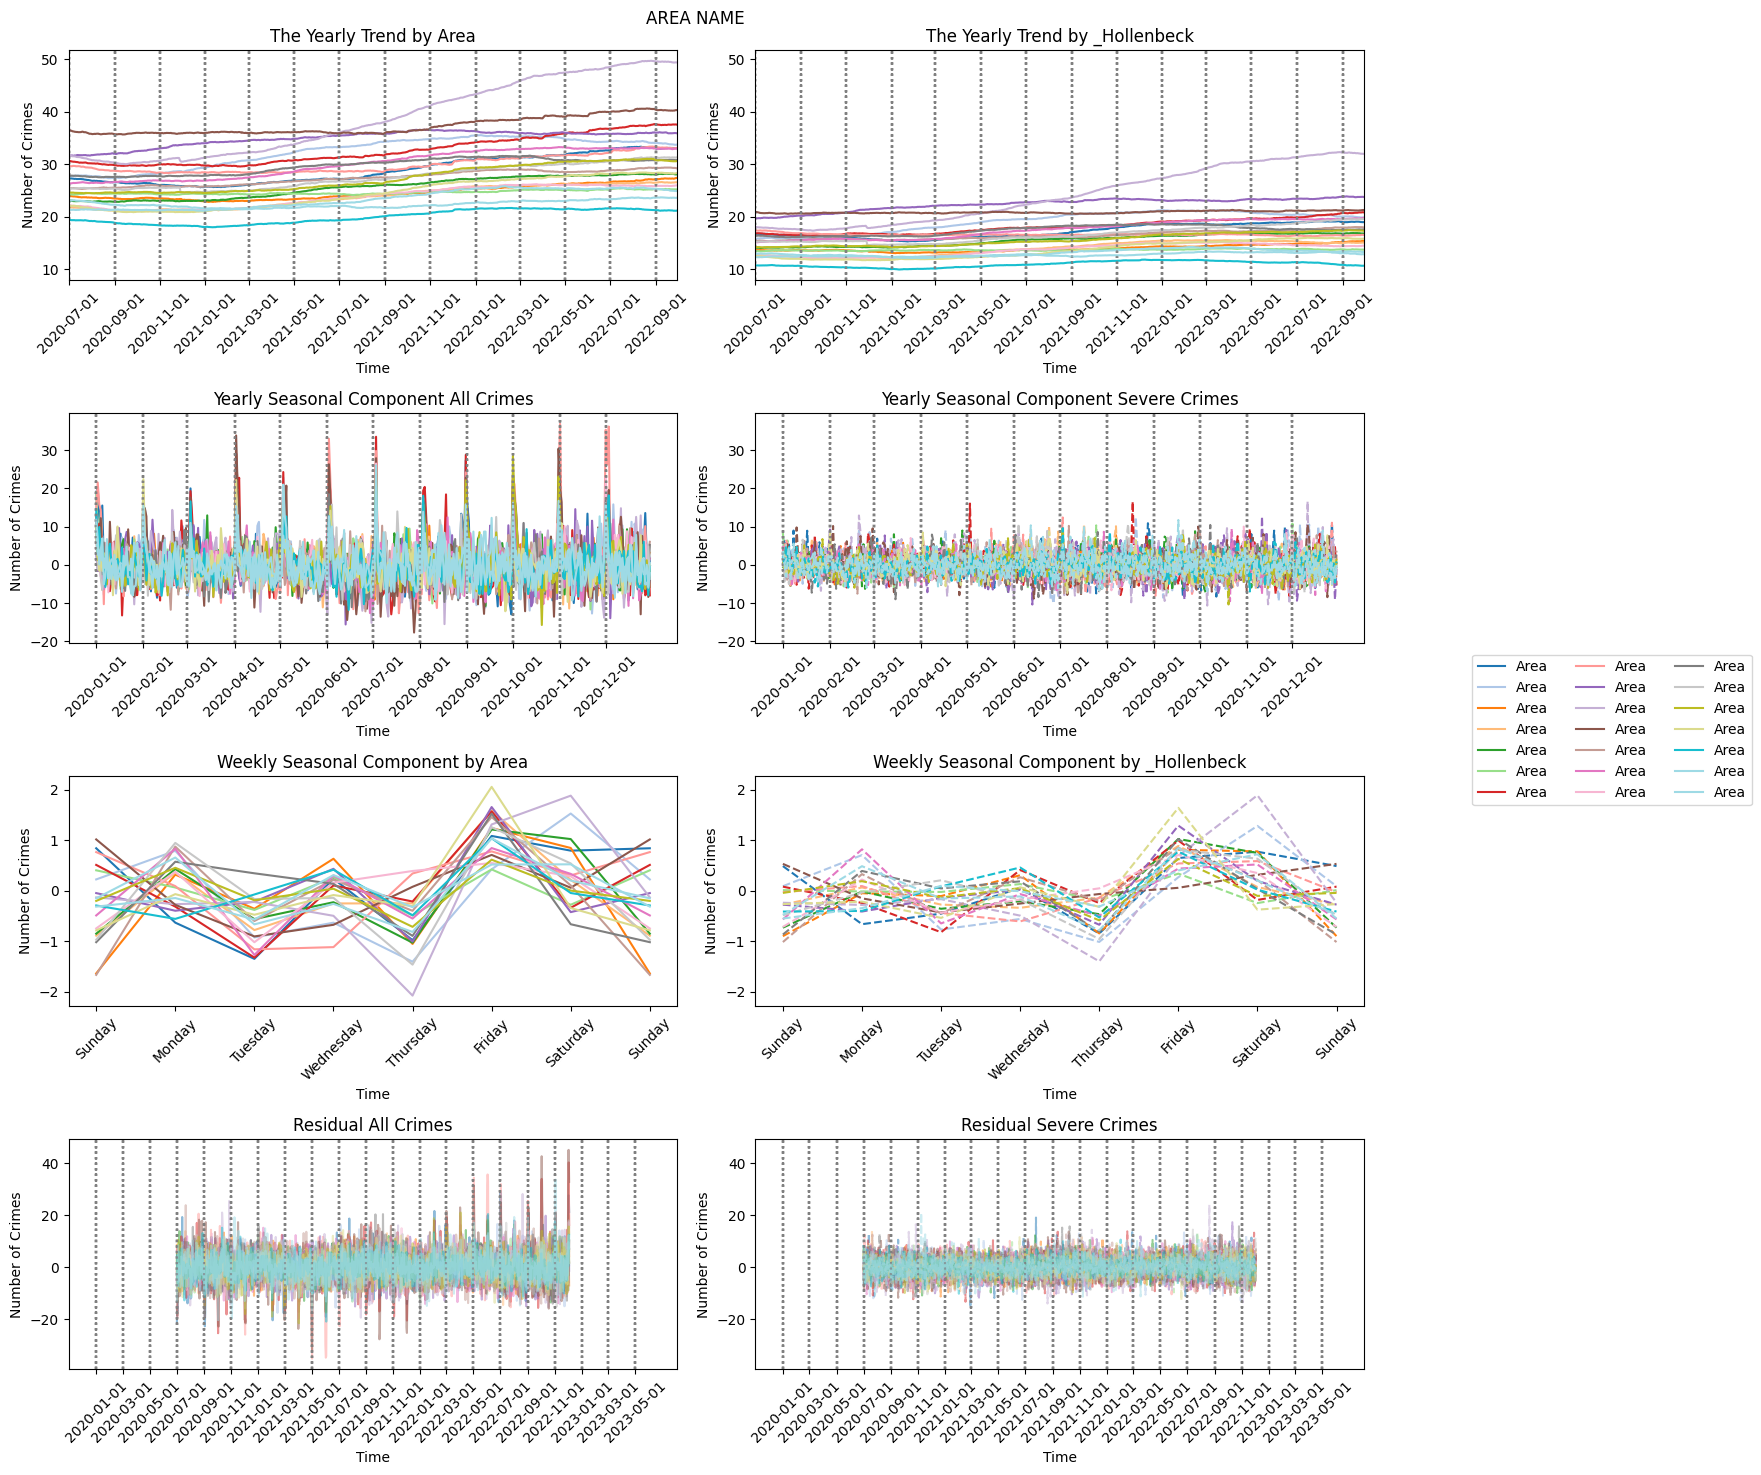

In [ ]:
partition_type = "AREA NAME"

fig = plt.figure(figsize=(14,15))
axes = fig.subplots(nrows=4, ncols=2)
axes[0,0].sharey(axes[0,1])
axes[1,0].sharey(axes[1,1])
axes[2,0].sharey(axes[2,1])
axes[3,0].sharey(axes[3,1])

if partition_type == "Crime":
  for i, crime in enumerate(['Crime 510', 'Crime 624', 'Crime 330', 'Crime 354',
        'Crime 740', 'Crime 310', 'Crime 440', 'Crime 230', 'Crime 626',
        'Crime 420', 'Crime 331', 'Crime 341', 'Crime 210', 'Crime 442',
        'Crime 745', 'Crime 930', 'Crime 888', 'Crime 761', 'Crime 236',
        'Crime 901', 'Crime 998']):
    cmap=plt.get_cmap('tab20')
    time_series = data[data[crime] == True]["Violent/Property"].astype(int).copy()
    time_series.index = pd.DatetimeIndex(data[data[crime] == True]['DATETIME OCC'])
    # We snsure that we are only getting the train dataset
    crime_severe_daily_crimes = np.array(time_series.resample('D').sum()[:-100])[:int(0.7*n)]
    crime_all_daily_crimes = np.array(time_series.resample('D').count()[:-100])[:int(0.7*n)]
    all_ts, train_all_T_yearly, train_all_S_yearly, train_all_S_weekly, \
      train_all_residual = split_series_compare(crime_all_daily_crimes, period_yearly=365, period_weekly=7, color=cmap(i), line="-", label=f"{crime[-3:]}", axes=axes[:,0], severity="All Crimes")
    all_ts, train_all_T_yearly, train_all_S_yearly, train_all_S_weekly, \
      train_all_residual = split_series_compare(crime_severe_daily_crimes, period_yearly=365, period_weekly=7, color=cmap(i), line="--", label=f"_{crime}", axes=axes[:,1], severity="Severe Crimes")
  plt.suptitle("Crimes")
elif partition_type == "Premise":
  for i, premise in enumerate(['Premise 101', 'Premise 501', 'Premise 502',
       'Premise 108', 'Premise 203', 'Premise 102', 'Premise 122',
       'Premise 707', 'Premise 104', 'Premise 404', 'Premise 210']):
    time_series = data[data[premise] == True]["Violent/Property"].astype(int).copy()
    time_series.index = pd.DatetimeIndex(data[data[premise] == True]['DATETIME OCC'])
    # We snsure that we are only getting the train dataset
    premise_severe_daily_crimes = np.array(time_series.resample('D').sum()[:-100])[:int(0.7*n)]
    premise_all_daily_crimes = np.array(time_series.resample('D').count()[:-100])[:int(0.7*n)]
    all_ts, train_all_T_yearly, train_all_S_yearly, train_all_S_weekly, \
      train_all_residual = split_series_compare(premise_all_daily_crimes, period_yearly=365, period_weekly=7, color=f"C{i}", line="-", label=f"{premise}", axes=axes[:,0], severity="All Crimes")
    all_ts, train_all_T_yearly, train_all_S_yearly, train_all_S_weekly, \
      train_all_residual = split_series_compare(premise_severe_daily_crimes, period_yearly=365, period_weekly=7, color=f"C{i}", line="--", label=f"_{premise}", axes=axes[:,1], severity="Severe Crimes")
  plt.suptitle("Premises")
elif partition_type == "Ethnicity":
  for i, ethno in enumerate(["H", "W", "B", "X", "O", "A"]):
    time_series = data[data[f"Vict {ethno}"] == True]["Violent/Property"].astype(int).copy()
    time_series.index = pd.DatetimeIndex(data[data[f"Vict {ethno}"] == True]['DATETIME OCC'])
    # We snsure that we are only getting the train dataset
    ethno_severe_daily_crimes = np.array(time_series.resample('D').sum()[:-100])[:int(0.7*n)]
    ethno_all_daily_crimes = np.array(time_series.resample('D').count()[:-100])[:int(0.7*n)]
    all_ts, train_all_T_yearly, train_all_S_yearly, train_all_S_weekly, \
      train_all_residual = split_series_compare(ethno_all_daily_crimes, period_yearly=365, period_weekly=7, color=f"C{i}", line="-", label=f"{ethno}", axes=axes[:,0], severity="All Crimes")
    all_ts, train_all_T_yearly, train_all_S_yearly, train_all_S_weekly, \
      train_all_residual = split_series_compare(ethno_severe_daily_crimes, period_yearly=365, period_weekly=7, color=f"C{i}", line="--", label=f"_{ethno}", axes=axes[:,1], severity="Severe Crimes")
  plt.suptitle("Ethnicities")
elif partition_type == "Sex":
  for i, sex in enumerate(["Male", "Female"]):
    time_series = data[data[f"Vict {sex}"] == True]["Violent/Property"].astype(int).copy()
    time_series.index = pd.DatetimeIndex(data[data[f"Vict {sex}"] == True]['DATETIME OCC'])
    # Only get the train datset
    gender_severe_daily_crimes = np.array(time_series.resample('D').sum()[:-100])[:int(0.7*n)]
    gender_all_daily_crimes = np.array(time_series.resample('D').count()[:-100])[:int(0.7*n)]
    all_ts, train_all_T_yearly, train_all_S_yearly, train_all_S_weekly, \
      train_all_residual = split_series_compare(gender_all_daily_crimes, period_yearly=365, period_weekly=7, color=f"C{i}", line="-", label=f"{sex}", axes=axes[:,0], severity="All Crimes")
    all_ts, train_all_T_yearly, train_all_S_yearly, train_all_S_weekly, \
      train_all_residual = split_series_compare(gender_severe_daily_crimes, period_yearly=365, period_weekly=7, color=f"C{i}", line="--", label=f"_{sex}", axes=axes[:,1], severity="Severe Crimes")
  plt.suptitle("Sex")
elif partition_type == "Weapon":
  for i, weapon in enumerate(['Weapon 400', 'Weapon 500', 'Weapon 511', 'Weapon 102']):
    time_series = data[data[weapon] == True]["Violent/Property"].astype(int).copy()
    time_series.index = pd.DatetimeIndex(data[data[weapon] == True]['DATETIME OCC'])
    # We snsure that we are only getting the train dataset
    weapon_severe_daily_crimes = np.array(time_series.resample('D').sum()[:-100])[:int(0.7*n)]
    weapon_all_daily_crimes = np.array(time_series.resample('D').count()[:-100])[:int(0.7*n)]
    all_ts, train_all_T_yearly, train_all_S_yearly, train_all_S_weekly, \
      train_all_residual = split_series_compare(weapon_all_daily_crimes, period_yearly=365, period_weekly=7, color=f"C{i}", line="-", label=f"{weapon}", axes=axes[:,0], severity="All Crimes")
    all_ts, train_all_T_yearly, train_all_S_yearly, train_all_S_weekly, \
      train_all_residual = split_series_compare(weapon_severe_daily_crimes, period_yearly=365, period_weekly=7, color=f"C{i}", line="--", label=f"_{weapon}", axes=axes[:,1], severity="Severe Crimes")
  plt.suptitle("Weapon")
elif partition_type == "AREA NAME":
  for i, area in enumerate(['Newton', 'Hollywood', 'Van Nuys', 'Devonshire', 'Northeast', 'Harbor',
                'Southwest', 'Southeast', 'Pacific', 'Central', '77th Street', 'West LA',
                'Olympic', 'Topanga', 'N Hollywood', 'Wilshire', 'Rampart', 'West Valley',
                'Foothill', 'Mission', 'Hollenbeck']):
    cmap=plt.get_cmap('tab20')
    time_series = data[data["AREA NAME"] == area]["Violent/Property"].astype(int).copy()
    time_series.index = pd.DatetimeIndex(data[data["AREA NAME"] == area]['DATETIME OCC'])
    # We snsure that we are only getting the train dataset
    area_severe_daily_crimes = np.array(time_series.resample('D').sum()[:-100])[:int(0.7*n)]
    area_all_daily_crimes = np.array(time_series.resample('D').count()[:-100])[:int(0.7*n)]
    all_ts, train_all_T_yearly, train_all_S_yearly, train_all_S_weekly, \
      train_all_residual = split_series_compare(area_all_daily_crimes, period_yearly=365, period_weekly=7, color=cmap(i), line="-", label=f"Area", axes=axes[:,0], severity="All Crimes")

    all_ts, train_all_T_yearly, train_all_S_yearly, train_all_S_weekly, \
      train_all_residual = split_series_compare(area_severe_daily_crimes, period_yearly=365, period_weekly=7, color=cmap(i), line="--", label=f"_{area}", axes=axes[:,1], severity="Severe Crimes")
  plt.suptitle("AREA NAME")

elif partition_type == "Age":
  for i, age in enumerate([(0,10), (11,20), (21,30), (31,40), (41,50), (51,60), (61,70), (71,80)]):
    time_series = data[data["Vict Age"].between(age[0], age[1])]["Violent/Property"].astype(int).copy()
    time_series.index = pd.DatetimeIndex(data[data["Vict Age"].between(age[0], age[1])]['DATETIME OCC'])
    # We snsure that we are only getting the train dataset
    age_severe_daily_crimes = np.array(time_series.resample('D').sum()[:-100])[:int(0.7*n)]
    age_all_daily_crimes = np.array(time_series.resample('D').count()[:-100])[:int(0.7*n)]
    all_ts, train_all_T_yearly, train_all_S_yearly, train_all_S_weekly, \
      train_all_residual = split_series_compare(age_all_daily_crimes, period_yearly=365, period_weekly=7, color=f"C{i}", line="-", label=f"{age}", axes=axes[:,0], severity="All Crimes")
    all_ts, train_all_T_yearly, train_all_S_yearly, train_all_S_weekly, \
      train_all_residual = split_series_compare(age_severe_daily_crimes, period_yearly=365, period_weekly=7, color=f"C{i}", line="--", label=f"_{age}", axes=axes[:,1], severity="Severe Crimes")
  plt.suptitle("Age")
fig.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=10, ncol=3)
plt.tight_layout()
plt.savefig(f"{partition_type}.png")
plt.show()

# Fitting an ARIMA Model

### DETRENDED TIME SERIES FOR VIOLENT CRIMES AND ALL CRIMES

<Axes: title={'center': 'Violent Crime Time Series'}, xlabel='DATETIME OCC'>

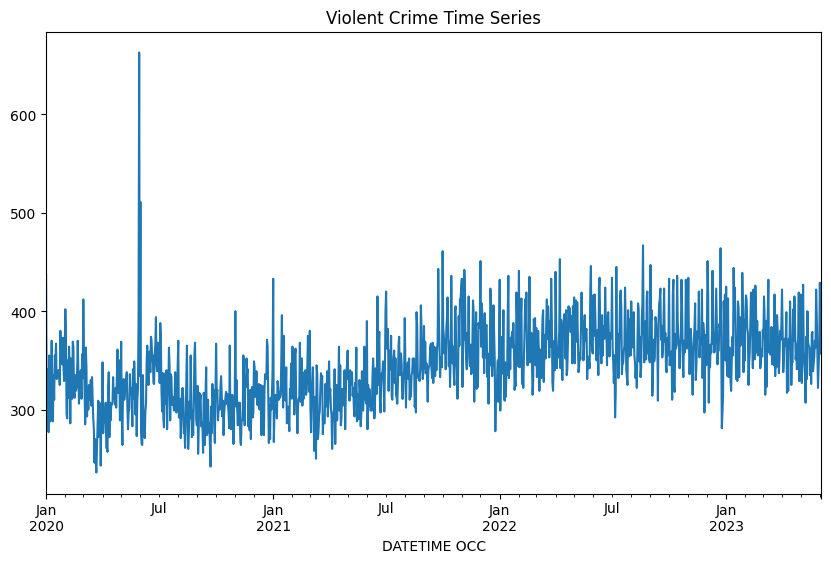

In [ ]:
train_severe.plot(title='Violent Crime Time Series', figsize=(10, 6))

<Axes: title={'center': 'All Crime Time Series'}, xlabel='DATETIME OCC'>

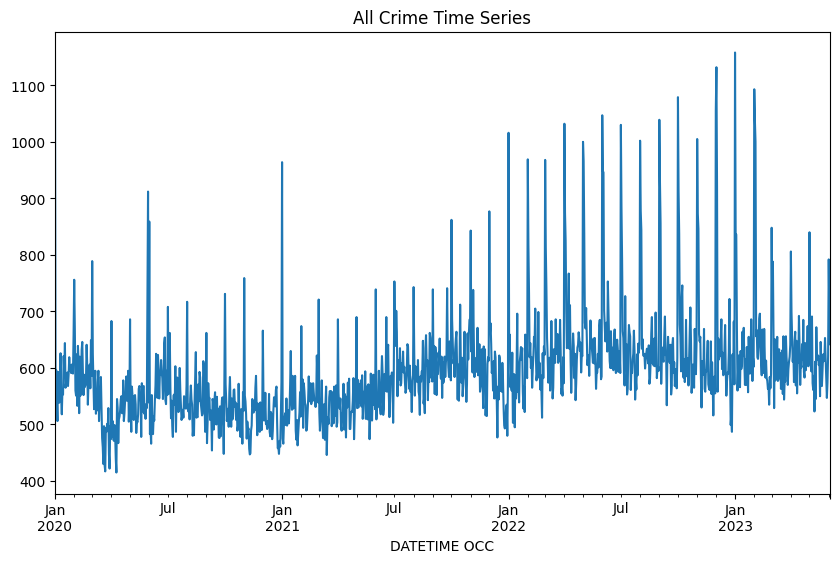

In [ ]:
train_all.plot(title='All Crime Time Series', figsize=(10, 6))

<Axes: title={'center': 'Differenced Violent Crime Time Series'}, xlabel='DATETIME OCC'>

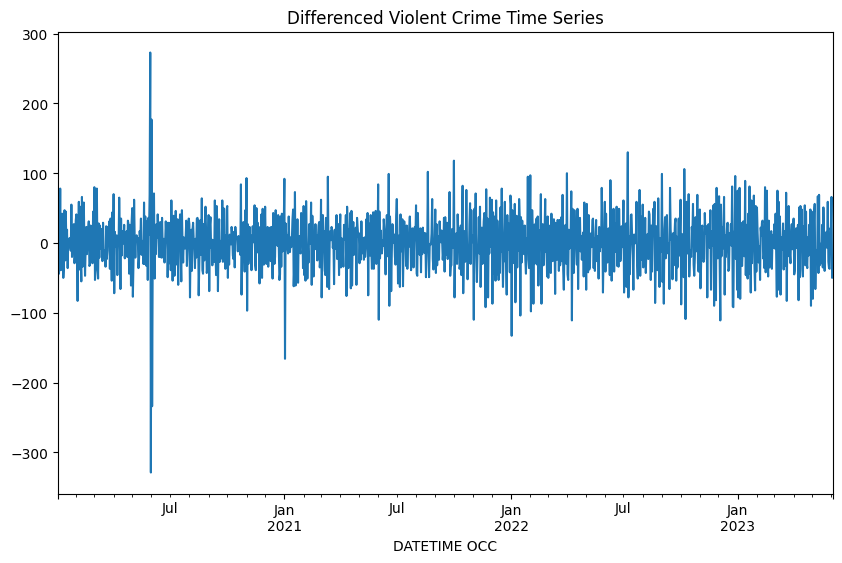

In [ ]:
# First-order differencing (for stationarity)
train_severe_diff = train_severe.diff().dropna()
# Plot to check
train_severe_diff.plot(title='Differenced Violent Crime Time Series', figsize=(10, 6))

<Axes: title={'center': 'Differenced All Crime Time Series'}, xlabel='DATETIME OCC'>

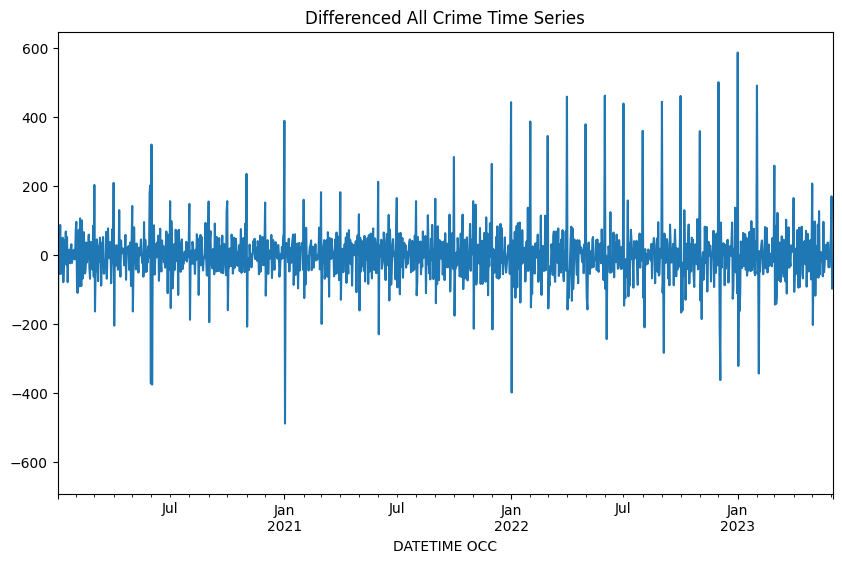

In [ ]:
# First-order differencing
train_all_diff = train_all.diff().dropna()
train_all_diff.plot(title='Differenced All Crime Time Series', figsize=(10, 6))


### FIT ARMA MODEL

In [ ]:
def sm_arma(time_series, p_max=6, q_max=6):
    """
    Build an ARMA model with statsmodel

    Parameters:
        time_series (ndarray): stationary time series
        p_max (int): maximum order of autoregressive model
        q_max (int): maximum order of moving average model

    Return:
        aic (float): aic of optimal model
        model (statsmodels.tsa.arima.model.ARIMA): optimal model
    """
    min_aic = float('inf')
    best_model = None
    params = None

    for p in range(1, p_max + 1):
        for q in range(1, q_max + 1):

            model = ARIMA(time_series, order=(p, 0, q), trend='c').fit(method="innovations_mle")

            if model.aic < min_aic:
                min_aic = model.aic
                best_model = model
                params = (p, q)


    return min_aic, best_model, params

In [ ]:
severe_aic, severe_arma_model, params = sm_arma(train_severe_diff.to_numpy())
print(severe_aic)
print(params)

12068.44273314639
(5, 5)


In [ ]:
severe_arma_model = ARIMA(train_severe_diff.to_numpy(), order=(5, 0, 5), trend='c').fit(method="innovations_mle")

## Best params for severe crimes are p=5, q=5

In [ ]:
all_aic, all_arma_model, params = sm_arma(train_all_diff.to_numpy())
print(all_aic)
print(params)

14242.617327196413
(6, 4)


In [ ]:
all_arma_model = ARIMA(train_all_diff.to_numpy(), order=(6, 0, 4), trend='c').fit(method="innovations_mle")

## Best params for all crime data are p=6, q=4

# PREDICTIONS

In [ ]:
plt.rcParams.update({
    'font.size': 14,            # Base font size
    'axes.titlesize': 18,       # Title size
    'axes.labelsize': 16,       # x/y label size
    'xtick.labelsize': 14,      # x-tick label size
    'ytick.labelsize': 14,      # y-tick label size
    'legend.fontsize': 14,      # Legend font size
})

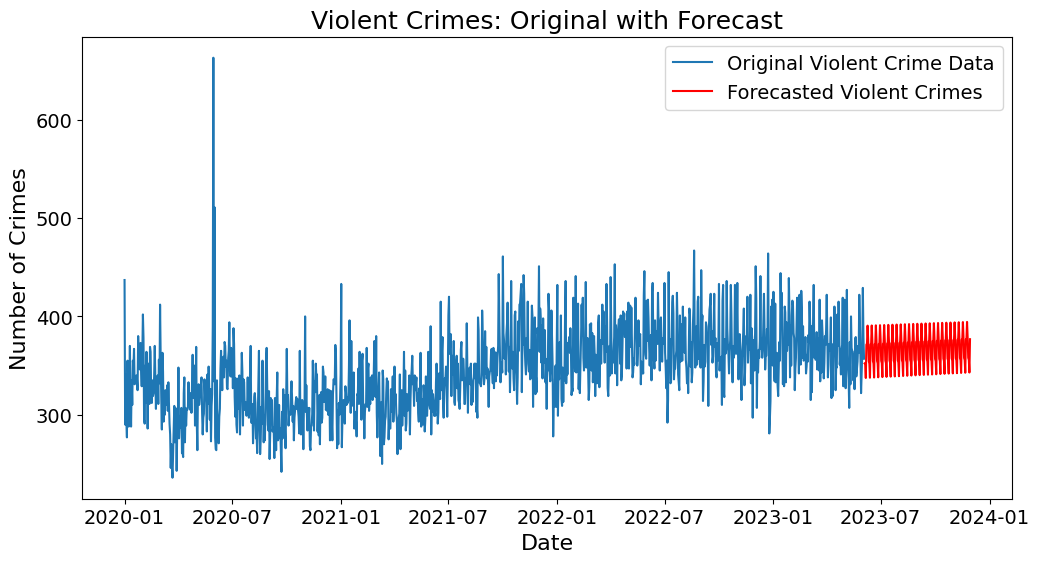

In [ ]:
n_periods = 179
forecast_diff = severe_arma_model.forecast(steps=n_periods)
# Add the forecasted differenced values to the last known value of the original time series
last_value = train_severe.iloc[-1]
forecast = np.r_[last_value, last_value + np.cumsum(forecast_diff)]
pred_severe = forecast[1:]

# Generate date range for future predictions
severe_forecast_index = pd.date_range(train_severe.index[-1], periods=n_periods+1)[1:]

# Plot original and forecasted data
plt.figure(figsize=(12, 6))
plt.plot(train_severe, label='Original Violent Crime Data')
plt.plot(severe_forecast_index, pred_severe, label='Forecasted Violent Crimes', color='red')
plt.title('Violent Crimes: Original with Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.legend()
plt.show()

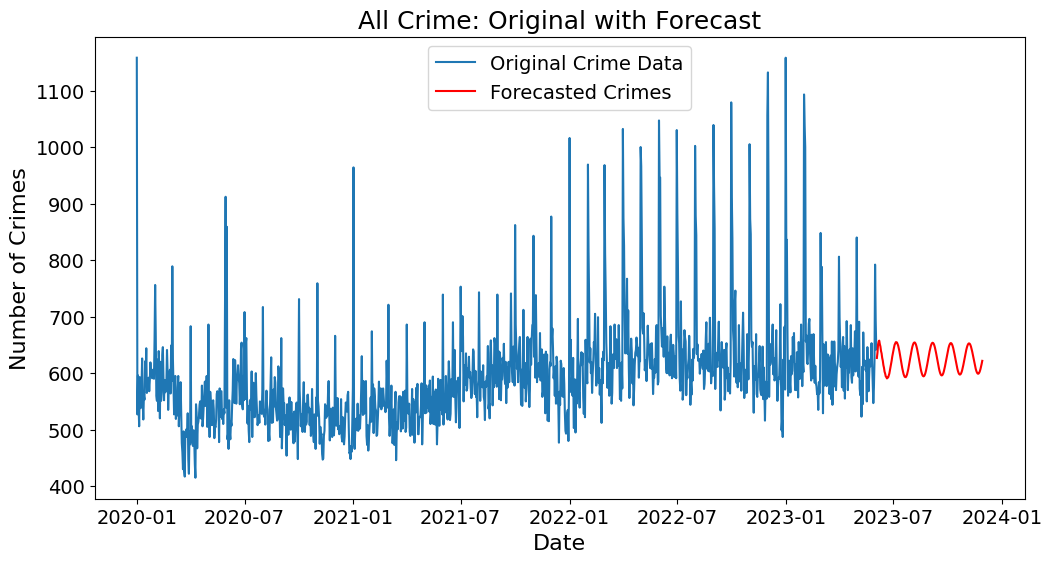

In [ ]:
n_periods = 179
forecast_diff = all_arma_model.forecast(steps=n_periods)
# Add the forecasted differenced values to the last known value of the original time series
last_value = train_all.iloc[-1]
pred_all = np.r_[last_value, last_value + np.cumsum(forecast_diff)][1:]


# Generate date range for future predictions
all_forecast_index = pd.date_range(train_all.index[-1], periods=n_periods+1)[1:]

# Plot original and forecasted data
plt.figure(figsize=(12, 6))
plt.plot(train_all, label='Original Crime Data')
plt.plot(all_forecast_index, pred_all, label='Forecasted Crimes', color='red')
plt.title('All Crime: Original with Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_severe = mean_absolute_error(val_severe, pred_severe)
mse_severe = mean_squared_error(val_severe, pred_severe)
print(f"severe Crime Forecast MAE: {mae_severe:.2f}")
print(f"severe Crime Forecast MSE: {mse_severe:.2f}")

severe Crime Forecast MAE: 32.31
severe Crime Forecast MSE: 1578.77


In [ ]:
mae_all = mean_absolute_error(val_all[:7], pred_all[:7])
mse_all = mean_squared_error(val_all, pred_all)
print(f"All Crime Forecast MAE: {mae_all:.2f}")
print(f"All Crime Forecast MSE: {mse_all:.2f}")

All Crime Forecast MAE: 36.65
All Crime Forecast MSE: 3092.50


In [ ]:
!apt-get -y install ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


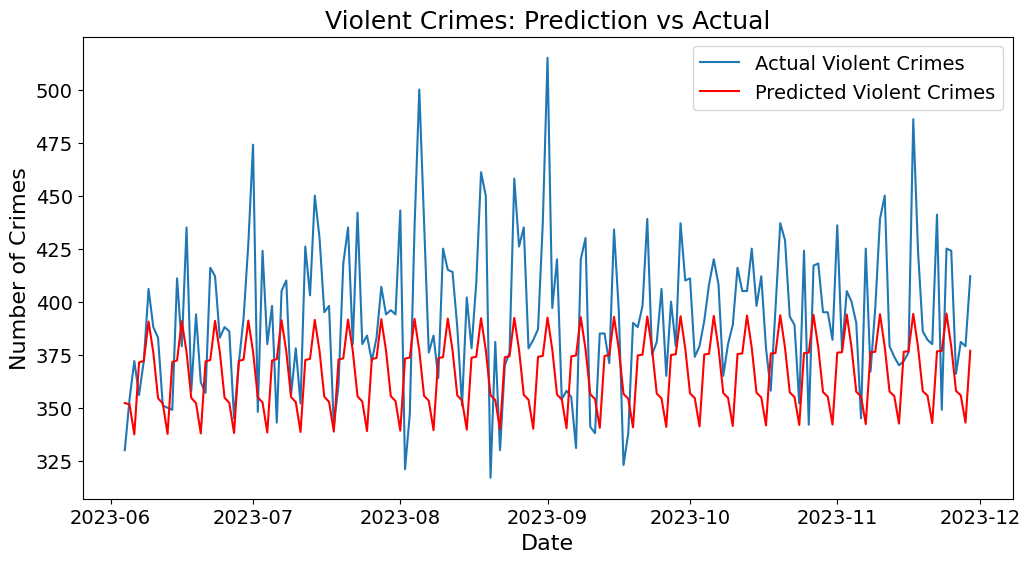

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(val_severe.index, val_severe, label='Actual Violent Crimes')
plt.plot(severe_forecast_index, pred_severe, label='Predicted Violent Crimes', color='red')
plt.title('Violent Crimes: Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.legend()
plt.show()

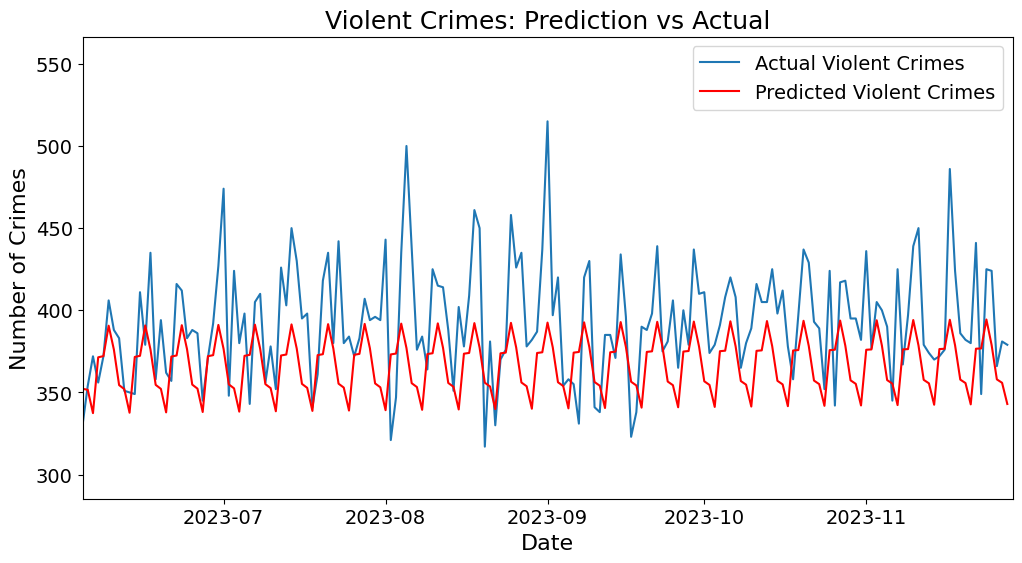

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title('Violent Crimes: Prediction vs Actual')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Crimes')

# Initialize the lines
actual_line, = ax.plot([], [], label='Actual Violent Crimes')
pred_line, = ax.plot([], [], label='Predicted Violent Crimes', color='red')

# Add legend
ax.legend()

# Set axis limits
ax.set_xlim(val_severe.index[0], val_severe.index[-1])
ax.set_ylim(min(min(val_severe), min(pred_severe)) * 0.9,
            max(max(val_severe), max(pred_severe)) * 1.1)

# Data for animation
actual_x = val_severe.index
actual_y = val_severe.values
pred_x = severe_forecast_index
pred_y = pred_severe

# Animation function
def update(frame):
    actual_line.set_data(actual_x[:frame], actual_y[:frame])
    pred_line.set_data(pred_x[:frame], pred_y[:frame])
    return actual_line, pred_line

# Create animation
num_frames = len(val_severe)
ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=50, blit=True)

# Save as gif
ani.save("violent_crimes_animation.gif", writer='pillow', fps=20)

<img src="violent_crimes_animation.gif" width="800"/>

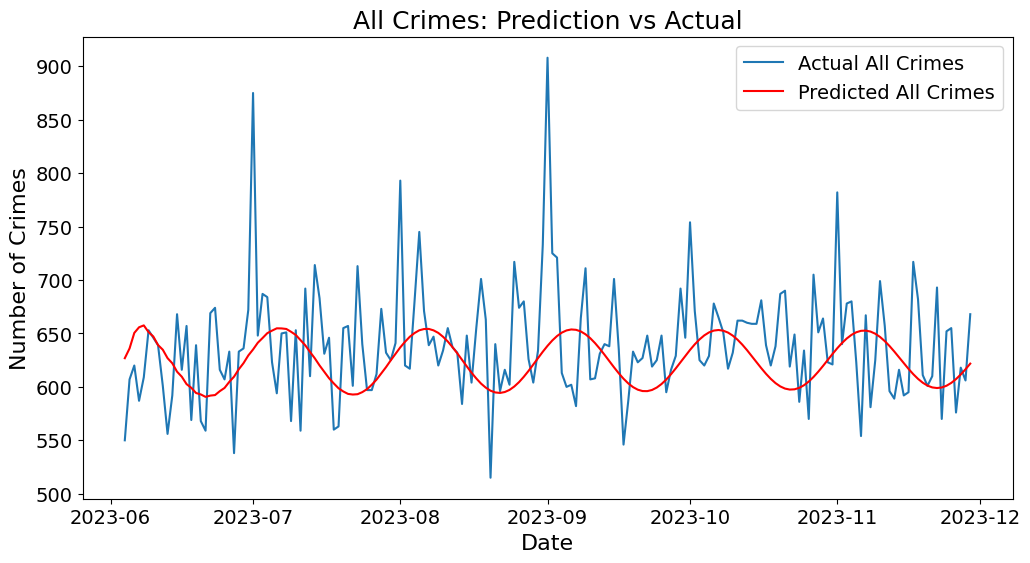

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(val_all.index, val_all, label='Actual All Crimes')
plt.plot(all_forecast_index, pred_all, label='Predicted All Crimes', color='red')
plt.title('All Crimes: Prediction vs Actual')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.show()

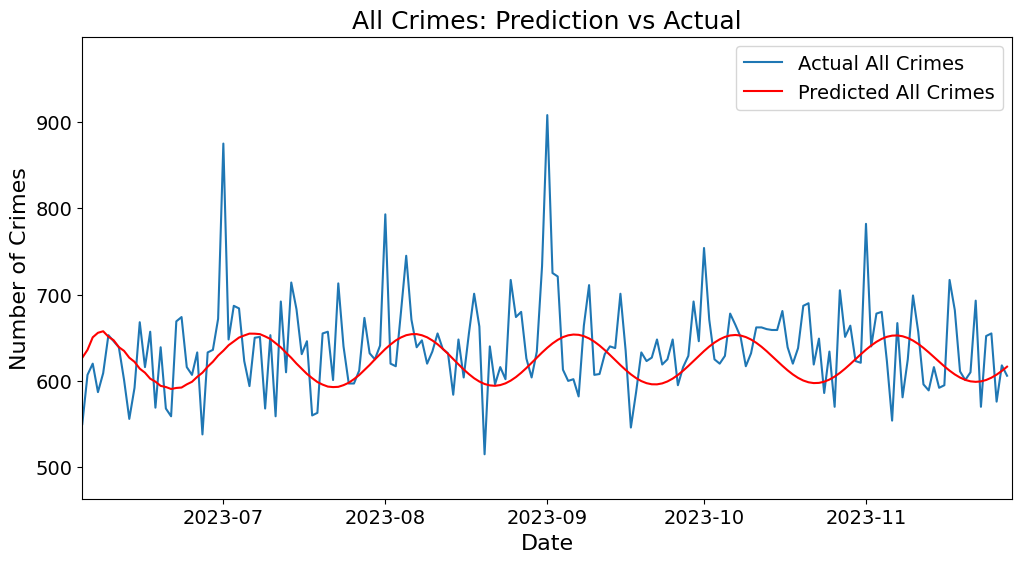

In [ ]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title('All Crimes: Prediction vs Actual')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Crimes')

# Initialize lines for animation
actual_line, = ax.plot([], [], label='Actual All Crimes')
pred_line, = ax.plot([], [], label='Predicted All Crimes', color='red')

# Add legend
ax.legend()

# Set axis limits
ax.set_xlim(val_all.index[0], val_all.index[-1])
ax.set_ylim(min(min(val_all), min(pred_all)) * 0.9,
            max(max(val_all), max(pred_all)) * 1.1)

# Data to animate
actual_x = val_all.index
actual_y = val_all.values
pred_x = all_forecast_index
pred_y = pred_all

# Update function
def update(frame):
    actual_line.set_data(actual_x[:frame], actual_y[:frame])
    pred_line.set_data(pred_x[:frame], pred_y[:frame])
    return actual_line, pred_line

# Animate
num_frames = len(val_all)
ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=50, blit=True)

# Save to gif
ani.save("all_crimes_animation.gif", writer='pillow', fps=20)


In [ ]:
horizons = [i for i in range(1, 179, 5)]

severe_mae_values = []
severe_mse_values = []
all_mae_values = []
all_mse_values = []
for h in horizons:
    severe_mae_h = mean_absolute_error(val_severe[:h], pred_severe[:h])
    severe_mae_values.append(severe_mae_h)

    severe_mse_h = mean_squared_error(val_severe[:h], pred_severe[:h])
    severe_mse_values.append(severe_mse_h)

    all_mae_h = mean_absolute_error(val_all[:h], pred_all[:h])
    all_mae_values.append(all_mae_h)

    all_mse_h = mean_squared_error(val_all[:h], pred_all[:h])
    all_mse_values.append(all_mse_h)

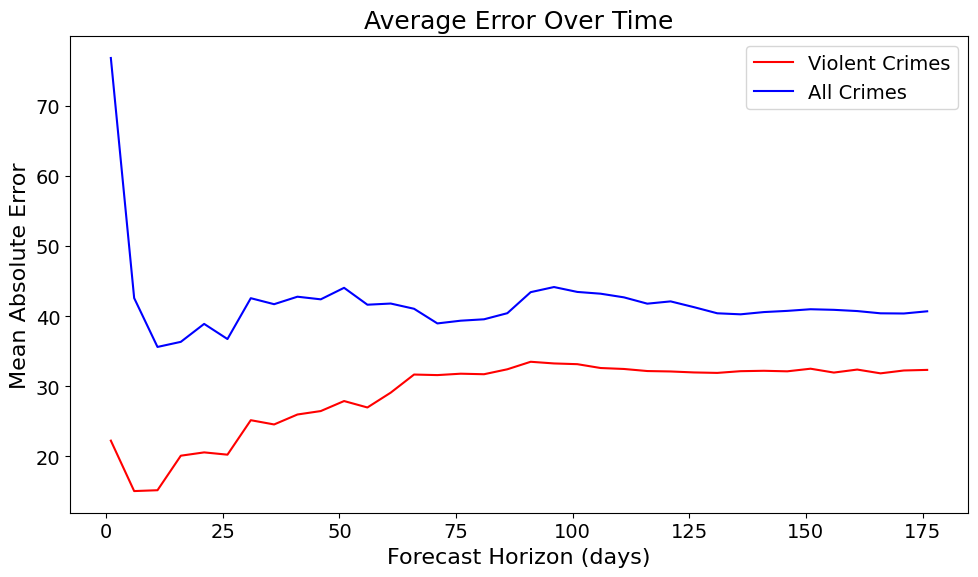

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(horizons, severe_mae_values, label='Violent Crimes', color='red')
plt.plot(horizons, all_mae_values, label='All Crimes', color='blue')
plt.title('Average Error Over Time')
plt.xlabel('Forecast Horizon (days)')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.tight_layout()
plt.show()

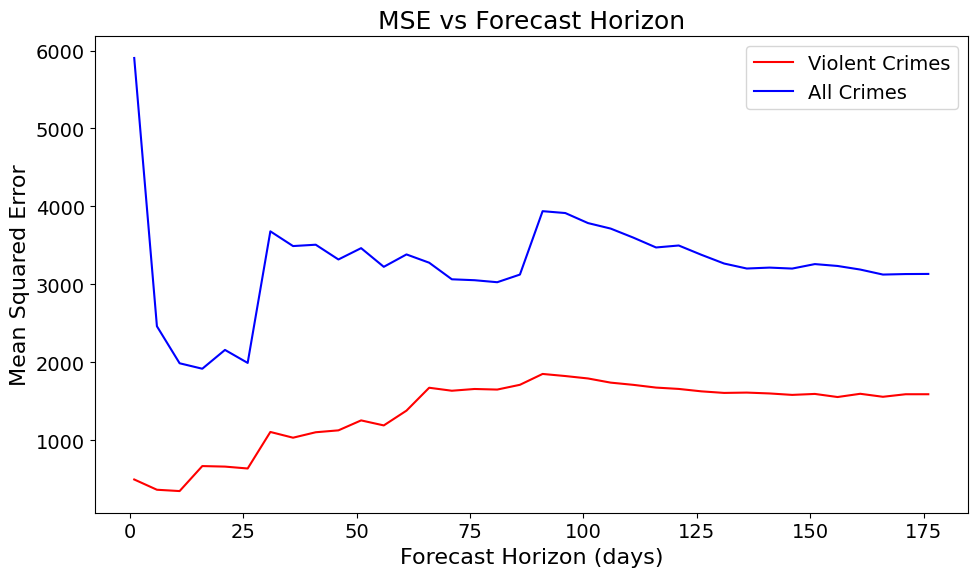

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(horizons, severe_mse_values, label='Violent Crimes', color='red')
plt.plot(horizons, all_mse_values, label='All Crimes', color='blue')
plt.title('MSE vs Forecast Horizon')
plt.xlabel('Forecast Horizon (days)')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.tight_layout()
plt.show()


# Time Invariant Analysis

In [ ]:
correlation_data = data.copy()

# Replace sexes to match US Census Bureau
correlation_data['Vict Descent'].replace({'C':'A', 'D':'A', 'F':'A', 'J':'A', 'K':'A', 'L':'A', 'V':'A', 'Z':'A', 'G':'P', 'S':'P', 'U':'P', 'O':'X', '-':'X'},
                                         inplace=True)

correlation_data['Vict Descent'].fillna("X", inplace=True)

# Use function to group ages like the Census Data
def grouping_function(age):
  if pd.isna(age):
    return 'X'
  if age < 5:
    return "Under 5"

  for i in range(1, 17):
    if age < 5*(i+1):
      return f"{5*i}-{5*i+4}"

  return "85+"
correlation_data["Age_Range"] = correlation_data["Vict Age"].map(grouping_function)



<ipython-input-105-aff2da435d5e>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  correlation_data['Vict Descent'].replace({'C':'A', 'D':'A', 'F':'A', 'J':'A', 'K':'A', 'L':'A', 'V':'A', 'Z':'A', 'G':'P', 'S':'P', 'U':'P', 'O':'X', '-':'X'},


In [ ]:
# Intialize masks
race_mask = correlation_data['Vict Descent'] != 'X'
age_mask = correlation_data['Age_Range'] != 'X'
sex_mask = correlation_data['Vict Male'] | data['Vict Female']

# Intialize order
race_list = ["W", "B", "I", "A", "P", "H"]
race_list_decoded = ["White", "Black", "Native American", "Asian", "Pacific Islander", "Hispanic"]
age_list = ["Under 5"]
for i in range(1, 17):
  age_list.append(f"{5*i}-{5*i+4}")
age_list.append("85+")
sex_list = [True, False]
sex_list_decoded = ["Male", "Female"]
type_list = [True, False]
type_list_decoded = ["Violent/Property", "Other"]

# Initialize prior distribution from Census Data
race_prior = np.array([1126052, 322553, 6614, 454585, 4573, 1829991])
race_prior = race_prior / race_prior.sum()
sex_age_prior = np.array([[102648, 104788, 114284, 115440, 131777, 169151, 180770, 156773, 138167, 126957, 127573, 115976, 104434, 85578, 59766, 37731, 24261, 25661],
                          [96719, 97720, 105166, 113499, 135967, 169753, 171261, 144112, 130798, 122097, 123474, 117678, 107571, 93280, 74478, 50239, 36015, 46335]])
sex_age_prior = sex_age_prior / sex_age_prior.sum()

# Restrict to columns needed
correlation_data = correlation_data[["Vict Descent", "Age_Range", "Vict Male", "Violent/Property"]]

In [ ]:
# Test proportions against outside data
def p_value_against_prior(input_data, prior, title, color, labels, xlabel=None):
  stat1 = power_divergence(input_data, prior*input_data.sum(), axis=None, lambda_="pearson").statistic            # Perason Test
  stat2 = power_divergence(input_data, prior*input_data.sum(), axis=None, lambda_="log-likelihood").statistic     # G Test
  ratio = input_data / (prior*input_data.sum())

  print("Proportion of Crimes / Proportion of Population:", ratio)

  if title:
    plt.figure(figsize=(12, 8))
    ratio_df = pd.DataFrame({'Proportion of Crimes / Proportion of Population': ratio, xlabel: labels})
    barplot(ratio_df, y='Proportion of Crimes / Proportion of Population', x=xlabel, color=color)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel("Proportion of Crimes / Proportion of Population", fontsize=16)
    plt.title(title, fontsize=20)
    ax = plt.gca()
    plt.text(.98, .98, f"Pearson Test Statistic: {int(stat1)}", transform=ax.transAxes, ha="right", va="top", fontsize=12)
    plt.text(.98, .95, f"G Test Statistic: {int(stat2)}", transform=ax.transAxes, ha="right", va="top", fontsize=12)
    plt.show()

Proportion of Crimes / Proportion of Population: [0.9913634  2.33362465 0.85051075 0.49160432 0.77684573 0.89763823]


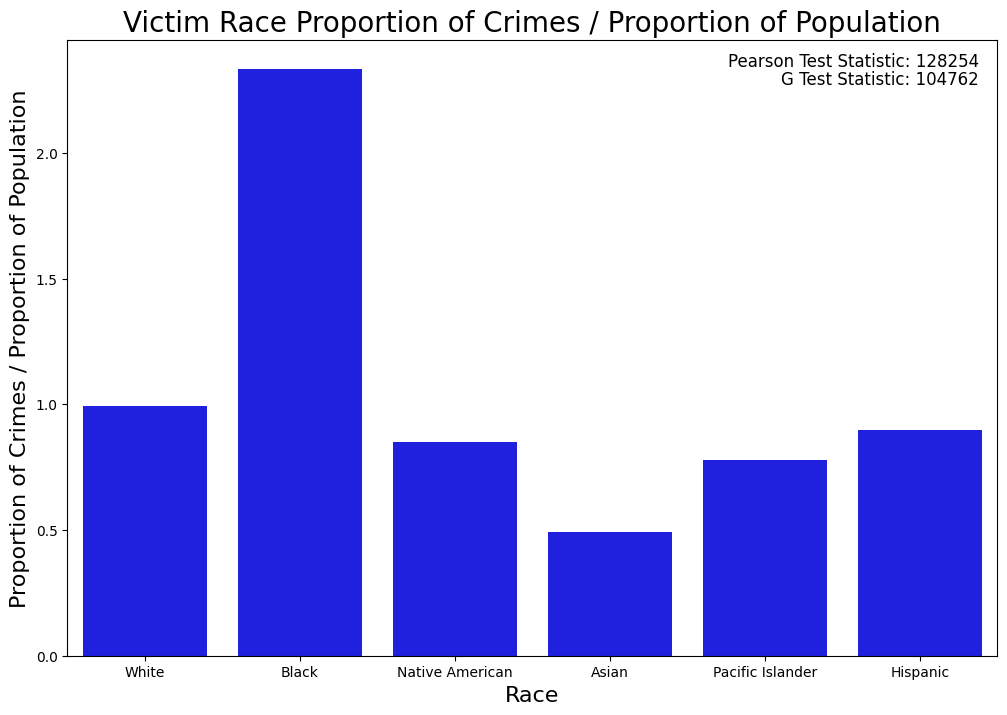

Proportion of Crimes / Proportion of Population: [1.06339134 0.93708101]


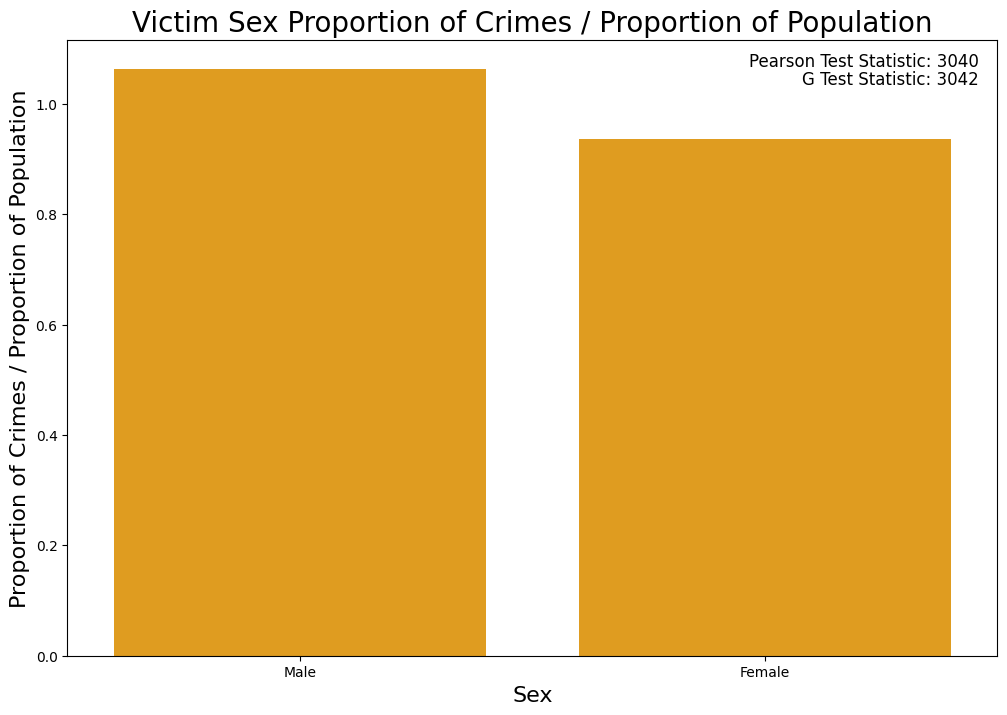

Proportion of Crimes / Proportion of Population: [0.03814191 0.07867436 0.22210316 0.63706607 1.54656987 1.56124836
 1.55426217 1.57962611 1.3944638  1.23119609 1.13366421 0.98952092
 0.87496139 0.70150574 0.58215325 0.5018362  0.39265268 0.27366577]


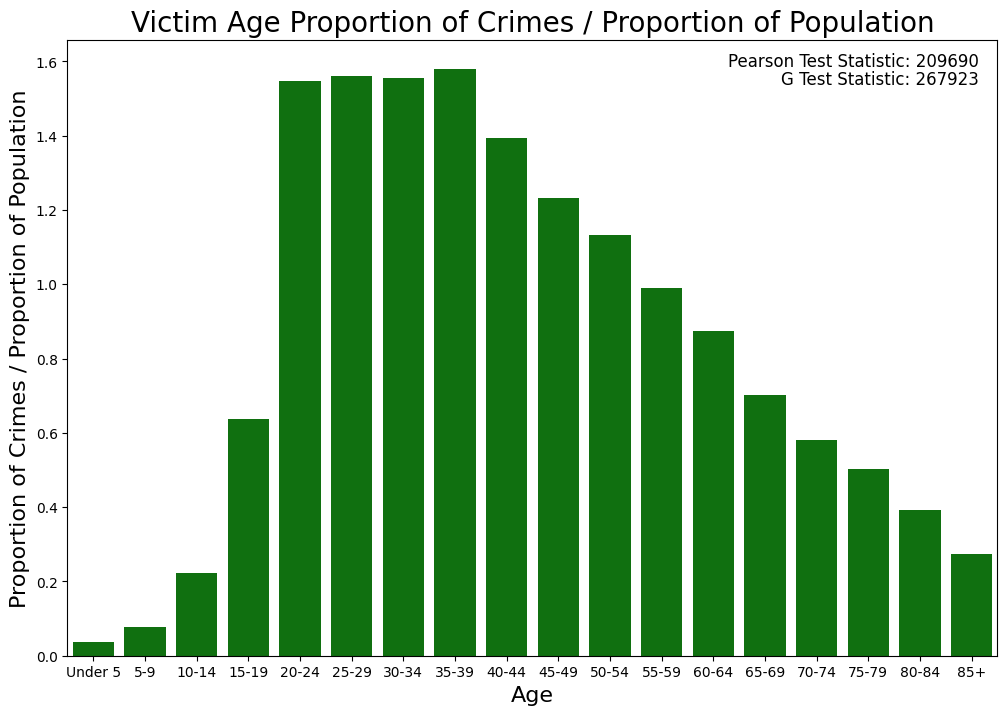

Proportion of Crimes / Proportion of Population: [0.03530354 0.06931747 0.17027902 0.53651387 1.33307268 1.48720004
 1.50956471 1.62573436 1.44638879 1.30182445 1.26129276 1.13730631
 1.04236937 0.83304226 0.71825635 0.59445758 0.45995076 0.33718525
 0.03994353 0.089034   0.28118144 0.69571955 1.51566055 1.66618707
 1.63660149 1.56721123 1.37238344 1.18789686 1.03044702 0.86789901
 0.73494954 0.59813815 0.48713642 0.44370159 0.35519975 0.23956686]


In [ ]:
# Test and plot proportions against census data
race_data = correlation_data[race_mask]["Vict Descent"].value_counts()[race_list].values
sex_data = correlation_data[sex_mask]["Vict Male"].value_counts().reindex(index=sex_list).values
age_data = correlation_data[age_mask]["Age_Range"].value_counts()[age_list].values

iterables = [sex_list, age_list]
multi_index = pd.MultiIndex.from_product(iterables, names=["Vict Male", "Age_Range"])
sex_age_data = correlation_data[sex_mask & age_mask].groupby("Vict Male")["Age_Range"].value_counts()[multi_index].values

p_value_against_prior(race_data, race_prior, "Victim Race Proportion of Crimes / Proportion of Population", "b", race_list_decoded, xlabel="Race")
p_value_against_prior(sex_data, sex_age_prior.sum(axis=1), "Victim Sex Proportion of Crimes / Proportion of Population", "orange", sex_list_decoded, xlabel="Sex")
p_value_against_prior(age_data, sex_age_prior.sum(axis=0), "Victim Age Proportion of Crimes / Proportion of Population", "green", age_list, xlabel="Age")
p_value_against_prior(sex_age_data, sex_age_prior.flatten(), None, None, None)

In [ ]:
# Test for Independence
def independence_test(data, xlabel, ylabel, title, xname, yname):
  res = chi2_contingency(data)
  plt.figure(figsize=(12, 8))
  ind_df = pd.DataFrame(data/data.sum(axis=0), columns=ylabel, index=xlabel)
  df_melted = pd.melt(ind_df.reset_index(), id_vars='index', var_name='column', value_name='value')


  barplot(x='column', y='value', hue='index', data=df_melted, hue_order=xlabel)
  ax = plt.gca()
  plt.text(.98, .98, f"Chi-Square Statistic: {int(res.statistic)}", transform=ax.transAxes, ha="right", va="top", fontsize=12)
  plt.ylabel("Proportion", fontsize=16)
  plt.xlabel(yname, fontsize=16)
  plt.legend(title=xname, fontsize=16, loc="upper left")
  plt.title(title, fontsize=20)
  plt.show()

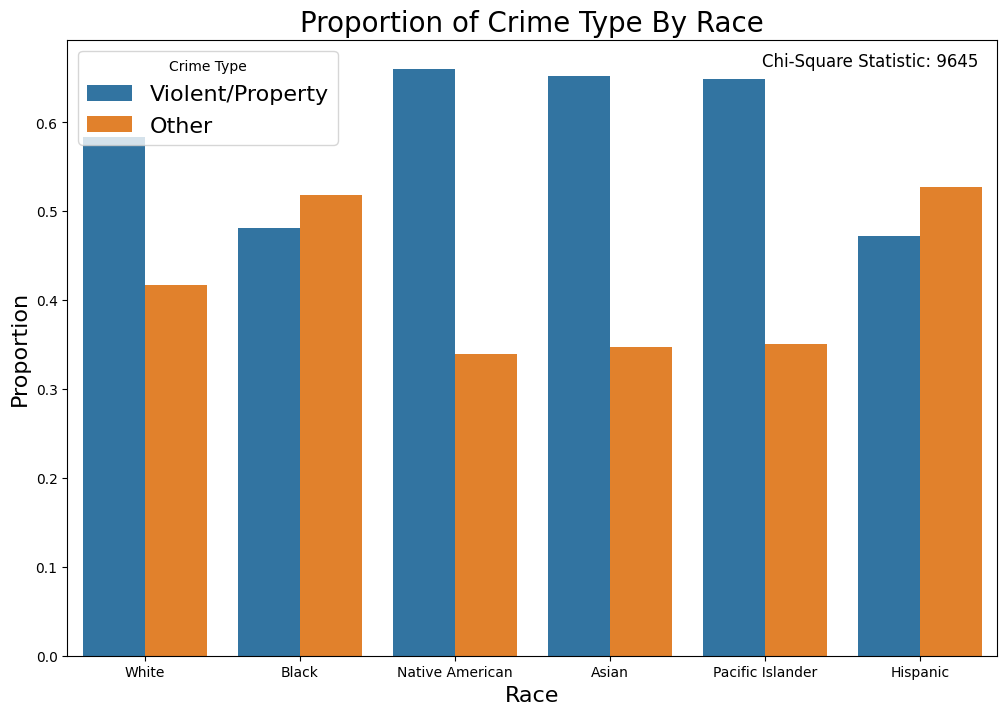

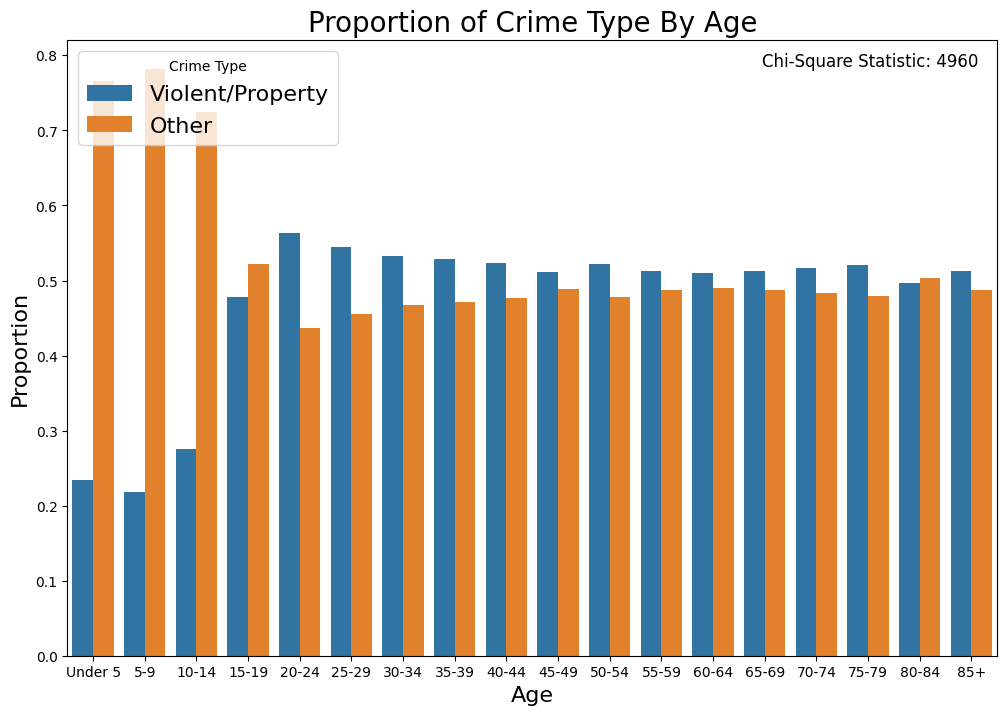

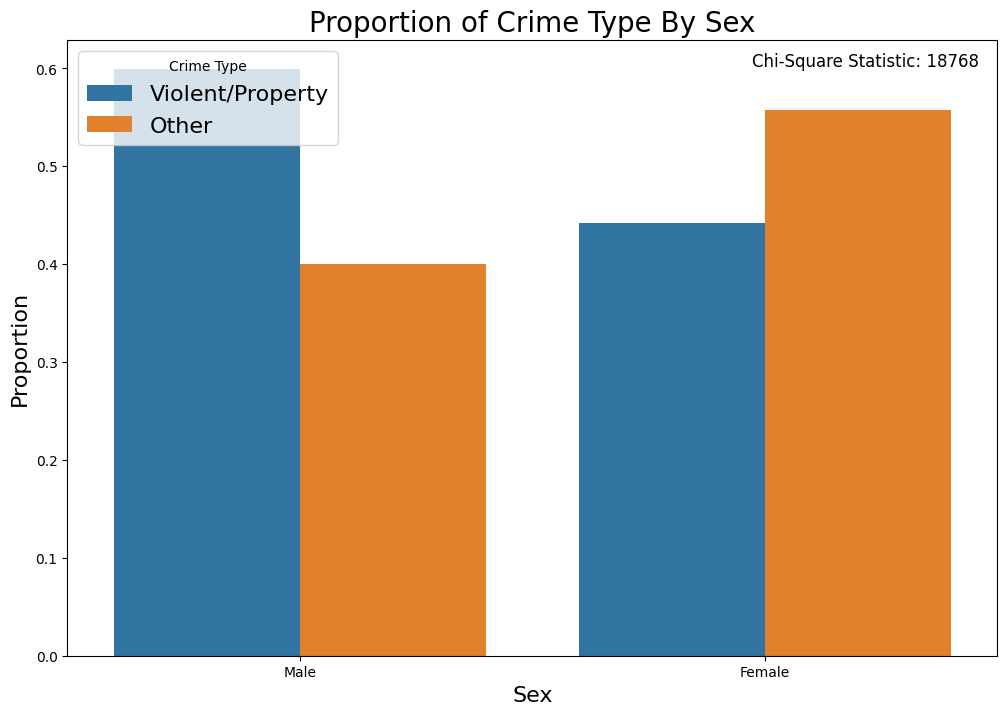

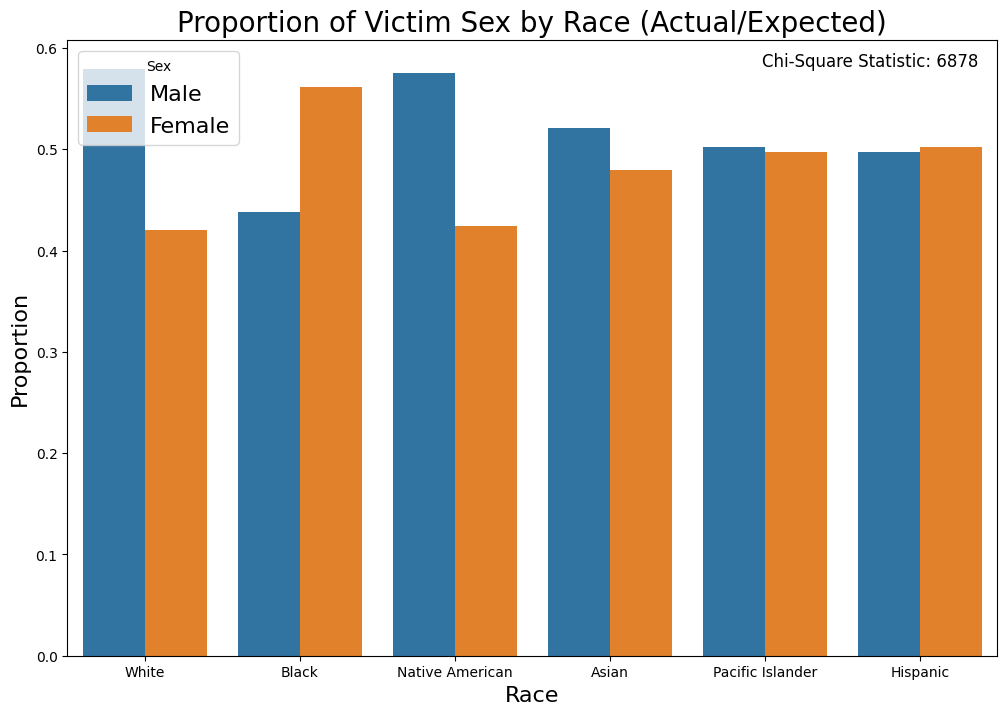

In [ ]:
# Test and plot Independence
iterables = [type_list, race_list]
multi_index = pd.MultiIndex.from_product(iterables, names=["Violent/Property", "Vict Descent"])
race_crime_data = correlation_data[race_mask].groupby("Violent/Property")["Vict Descent"].value_counts()[multi_index].values.reshape(len(type_list), len(race_list))
independence_test(race_crime_data, type_list_decoded, race_list_decoded, "Proportion of Crime Type By Race", "Crime Type", "Race")

iterables = [type_list, age_list]
multi_index = pd.MultiIndex.from_product(iterables, names=["Violent/Property", "Age_Range"])
age_crime_data = correlation_data[age_mask].groupby("Violent/Property")["Age_Range"].value_counts()[multi_index].values.reshape(len(type_list), len(age_list))
independence_test(age_crime_data, type_list_decoded, age_list, "Proportion of Crime Type By Age", "Crime Type", "Age")

iterables = [type_list, sex_list]
multi_index = pd.MultiIndex.from_product(iterables, names=["Violent/Property", "Vict Male"])
sex_crime_data = correlation_data[sex_mask].groupby("Violent/Property")["Vict Male"].value_counts()[multi_index].values.reshape(len(type_list), len(sex_list))
independence_test(sex_crime_data, type_list_decoded, sex_list_decoded, "Proportion of Crime Type By Sex", "Crime Type", "Sex")

iterables = [sex_list, race_list]
multi_index = pd.MultiIndex.from_product(iterables, names=["Vict Male", "Vict Descent"])
race_sex_data = correlation_data[race_mask & sex_mask].groupby("Vict Male")["Vict Descent"].value_counts()[multi_index].values.reshape(len(type_list), len(race_list))
independence_test(race_sex_data, sex_list_decoded, race_list_decoded, "Proportion of Victim Sex by Race (Actual/Expected)", "Sex", "Race")